# 데이터 선정
### 일본 도쿄의 *2005 ~ 2019년도*의 부동산 거래 데이터
### 집값 예측을 **데이터** 만으로 얼마나 정확하게 예측할수 있을까? 라는 의문을 가지고 선정
### 해외에서 문화와 환경이 가장 비슷한 일본을 중심으로 
### 한국의 부동산과의 차이점에 관한 인사이트로 얻을수 있을것으로 기대


In [ ]:
!pip install pandas-profiling==2.7.1
!pip install category_encoders
!pip install eli5
!pip install pdpbox
!pip install shap 

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingRegressor

# 파이프 라인 호출
from sklearn.pipeline import make_pipeline
from sklearn.feature_selection import f_regression, SelectKBest
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import KFold, cross_val_score, train_test_split ,GridSearchCV

# 인코더 호출
from category_encoders import OrdinalEncoder, TargetEncoder ,OneHotEncoder

# 회귀 모델
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV, Lasso, ElasticNet
from sklearn.metrics import r2_score
from xgboost import XGBRegressor

# 분류 모델
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier

In [ ]:
# 판다스 호출
import pandas as pd
import numpy as np

import warnings
warnings.filterwarnings('ignore')

# colab plot의 한글깨짐 해결
import matplotlib as mpl
import matplotlib.pyplot as plt
 
%config InlineBackend.figure_format = 'retina'
 
!apt -qq -y install fonts-nanum
 
import matplotlib.font_manager as fm
fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
font = fm.FontProperties(fname=fontpath, size=9)
plt.rc('font', family='NanumBarunGothic') 
mpl.font_manager._rebuild()

fonts-nanum is already the newest version (20170925-1).
0 upgraded, 0 newly installed, 0 to remove and 39 not upgraded.


# 주요 Column 소개
#### DistrictName : 실제 매물을 구할 지역이름
#### TimeToNearestStation : 지하철 역까지 걸리는 시간(분)           
#### TradePrice : 거래 가격
#### FloorPlan : 일본의 방구조 정보. EX) 1DK: 방1, 거실1 , 부엌1          
#### Area : 일본의 평방미터^2
#### PricePerTsubo : 일본의 평(Tsubo)당 가격 
#### Structure : 건물의 구조 : 철근, 목조..                 
#### Use : 건물의 사용 용도
#### BuildingYear : 건물 건축 년도
#### Year : 매물의 거래년도                                                  
#### Renovation : Renovation 여부         

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
tokyo = '/content/drive/MyDrive/13.csv'
df_original = pd.read_csv(tokyo,index_col='No')
df_original.isnull().sum()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Type                                0
Region                         184871
MunicipalityCode                    0
Prefecture                          0
Municipality                        0
DistrictName                      246
NearestStation                   1728
TimeToNearestStation            10339
MinTimeToNearestStation         10339
MaxTimeToNearestStation         10489
TradePrice                          0
FloorPlan                      228444
Area                                0
AreaIsGreaterFlag                   0
UnitPrice                      327072
PricePerTsubo                  327072
LandShape                      185273
Frontage                       203688
FrontageIsGreaterFlag               0
TotalFloorArea                 270150
TotalFloorAreaIsGreaterFlag         0
BuildingYear                    92279
PrewarBuilding                      0
Structure                       88218
Use                             97885
Purpose                        248844
Direction   

In [ ]:
# 프로파일링 파일 호출
import pandas_profiling
from pandas_profiling import ProfileReport

profile = ProfileReport(df_original)
profile

# EDA 및 전처리
### 결측치가 너무 많아(결측치 50% ~ 80%)  사용할 수 없는 너무 컬럼이 많아 평균으로 대체하는것은 데이터를 직접적으로 수정하는 것과 다를바 없을 것으로 예상해 삭제

In [ ]:
def preprocess(df):
  df_original.dropna(subset = ['FloorPlan'],inplace=True)
  df = df_original.drop(columns=['Period','PrewarBuilding','TimeToNearestStation','AreaIsGreaterFlag','MunicipalityCode','Municipality','MaxTimeToNearestStation','Purpose','Type','Region','Prefecture','UnitPrice','PricePerTsubo','LandShape','Frontage','FrontageIsGreaterFlag','TotalFloorArea','TotalFloorAreaIsGreaterFlag','Direction','Classification','Breadth','Remarks'])
  df.drop_duplicates(inplace = True)
  df = df[['TradePrice','FloorPlan','BuildingYear','Area','Year','Quarter','FloorAreaRatio','CoverageRatio','MinTimeToNearestStation']]
  df.dropna(subset = ['BuildingYear','FloorAreaRatio','MinTimeToNearestStation'],inplace=True)
  df = df[(df['TradePrice'] >= np.percentile(df['TradePrice'], 0.5)) & 
      (df['TradePrice'] <= np.percentile(df['TradePrice'], 99.5))]
  return df
  
df = preprocess(df_original)
df.reset_index(drop=True, inplace=True)

### 컬럼들의 상관관계 확인할수 있는 함수 작성 

In [ ]:
# Distribution 그래프(히스토그램/바 그래프)
def plotPerColumnDistribution(df, nGraphShown, nGraphPerRow):
    nunique = df.nunique()
    df = df[[col for col in df if nunique[col] > 1 and nunique[col] < 15]] # For displaying purposes, pick columns that have between 1 and 15 unique values
    nRow, nCol = df.shape
    columnNames = list(df)
    nGraphRow = (nCol + nGraphPerRow - 1) / nGraphPerRow
    plt.figure(num = None, figsize = (6 * nGraphPerRow, 8 * nGraphRow), dpi = 80, facecolor = 'w', edgecolor = 'k')
    for i in range(min(nCol, nGraphShown)):
        plt.subplot(nGraphRow, nGraphPerRow, i + 1)
        columnDf = df.iloc[:, i]
        if (not np.issubdtype(type(columnDf.iloc[0]), np.number)):
            valueCounts = columnDf.value_counts()
            valueCounts.plot.bar()
        else:
            columnDf.hist()
        plt.ylabel('counts')
        plt.xticks(rotation = 90)
        plt.title(f'{columnNames[i]} (column {i})')
    plt.tight_layout(pad = 1.0, w_pad = 1.0, h_pad = 1.0)
    plt.show()

In [ ]:
# CorrelationMatrix 함수
def plotCorrelationMatrix(df, graphWidth):
    filename = df.dataframeName
    df = df.dropna('columns') # drop columns with NaN
    df = df[[col for col in df if df[col].nunique() > 1]] # keep columns where there are more than 1 unique values
    if df.shape[1] < 2:
        print(f'No correlation plots shown: The number of non-NaN or constant columns ({df.shape[1]}) is less than 2')
        return
    corr = df.corr()
    plt.figure(num=None, figsize=(graphWidth, graphWidth), dpi=80, facecolor='w', edgecolor='k')
    corrMat = plt.matshow(corr, fignum = 1)
    plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
    plt.yticks(range(len(corr.columns)), corr.columns)
    plt.gca().xaxis.tick_bottom()
    plt.colorbar(corrMat)
    plt.title(f'Correlation Matrix for {filename}', fontsize=15)
    plt.show()

In [ ]:
# adj 평가지표
def adj_r2(r2, n, p):
    de = (n-1)*(1-r2**2)
    nu = n-p-1

    adj = 1-(de/nu)

    return adj

# Column들의 상관관계를 확인
#### 칼럼들이 종속적인 관계에 있나 확인할수있는 다중공산성 지표를 통해
#### 확인해보았으나 Vif 수치가 10을 넘는 컬럼이 없기때문에 서로 종속적인 관계에 있지 않음을 확인할 수 있다.

In [ ]:
from patsy import dmatrices
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

# 다중공선성 확인을 위한 DataFrame생성
vif_data = df.copy()

# numeric feature 추출
vif_data_num = SimpleImputer().fit_transform(vif_data[['TradePrice','Area','BuildingYear','CoverageRatio','FloorAreaRatio','Year','Quarter',
                                                       'MinTimeToNearestStation']])
vif_data_num = pd.DataFrame(vif_data_num, columns = ['TradePrice','Area','BuildingYear','CoverageRatio','FloorAreaRatio','Year','Quarter',
                                                       'MinTimeToNearestStation'])

# numeric feature들의 다중공선성 확인
num_features = 'Area+BuildingYear+CoverageRatio+FloorAreaRatio+Year+Quarter+MinTimeToNearestStation'
y, X = dmatrices("TradePrice~"+num_features, data = vif_data_num, return_type = "dataframe")
vif = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

print('VIF : ')
pd.DataFrame([vif], columns = X.columns)

VIF : 


,Intercept,Area,BuildingYear,CoverageRatio,FloorAreaRatio,Year,Quarter,MinTimeToNearestStation
0,316784.090024,1.141195,1.029104,2.439075,2.424555,1.02841,1.011046,1.257571


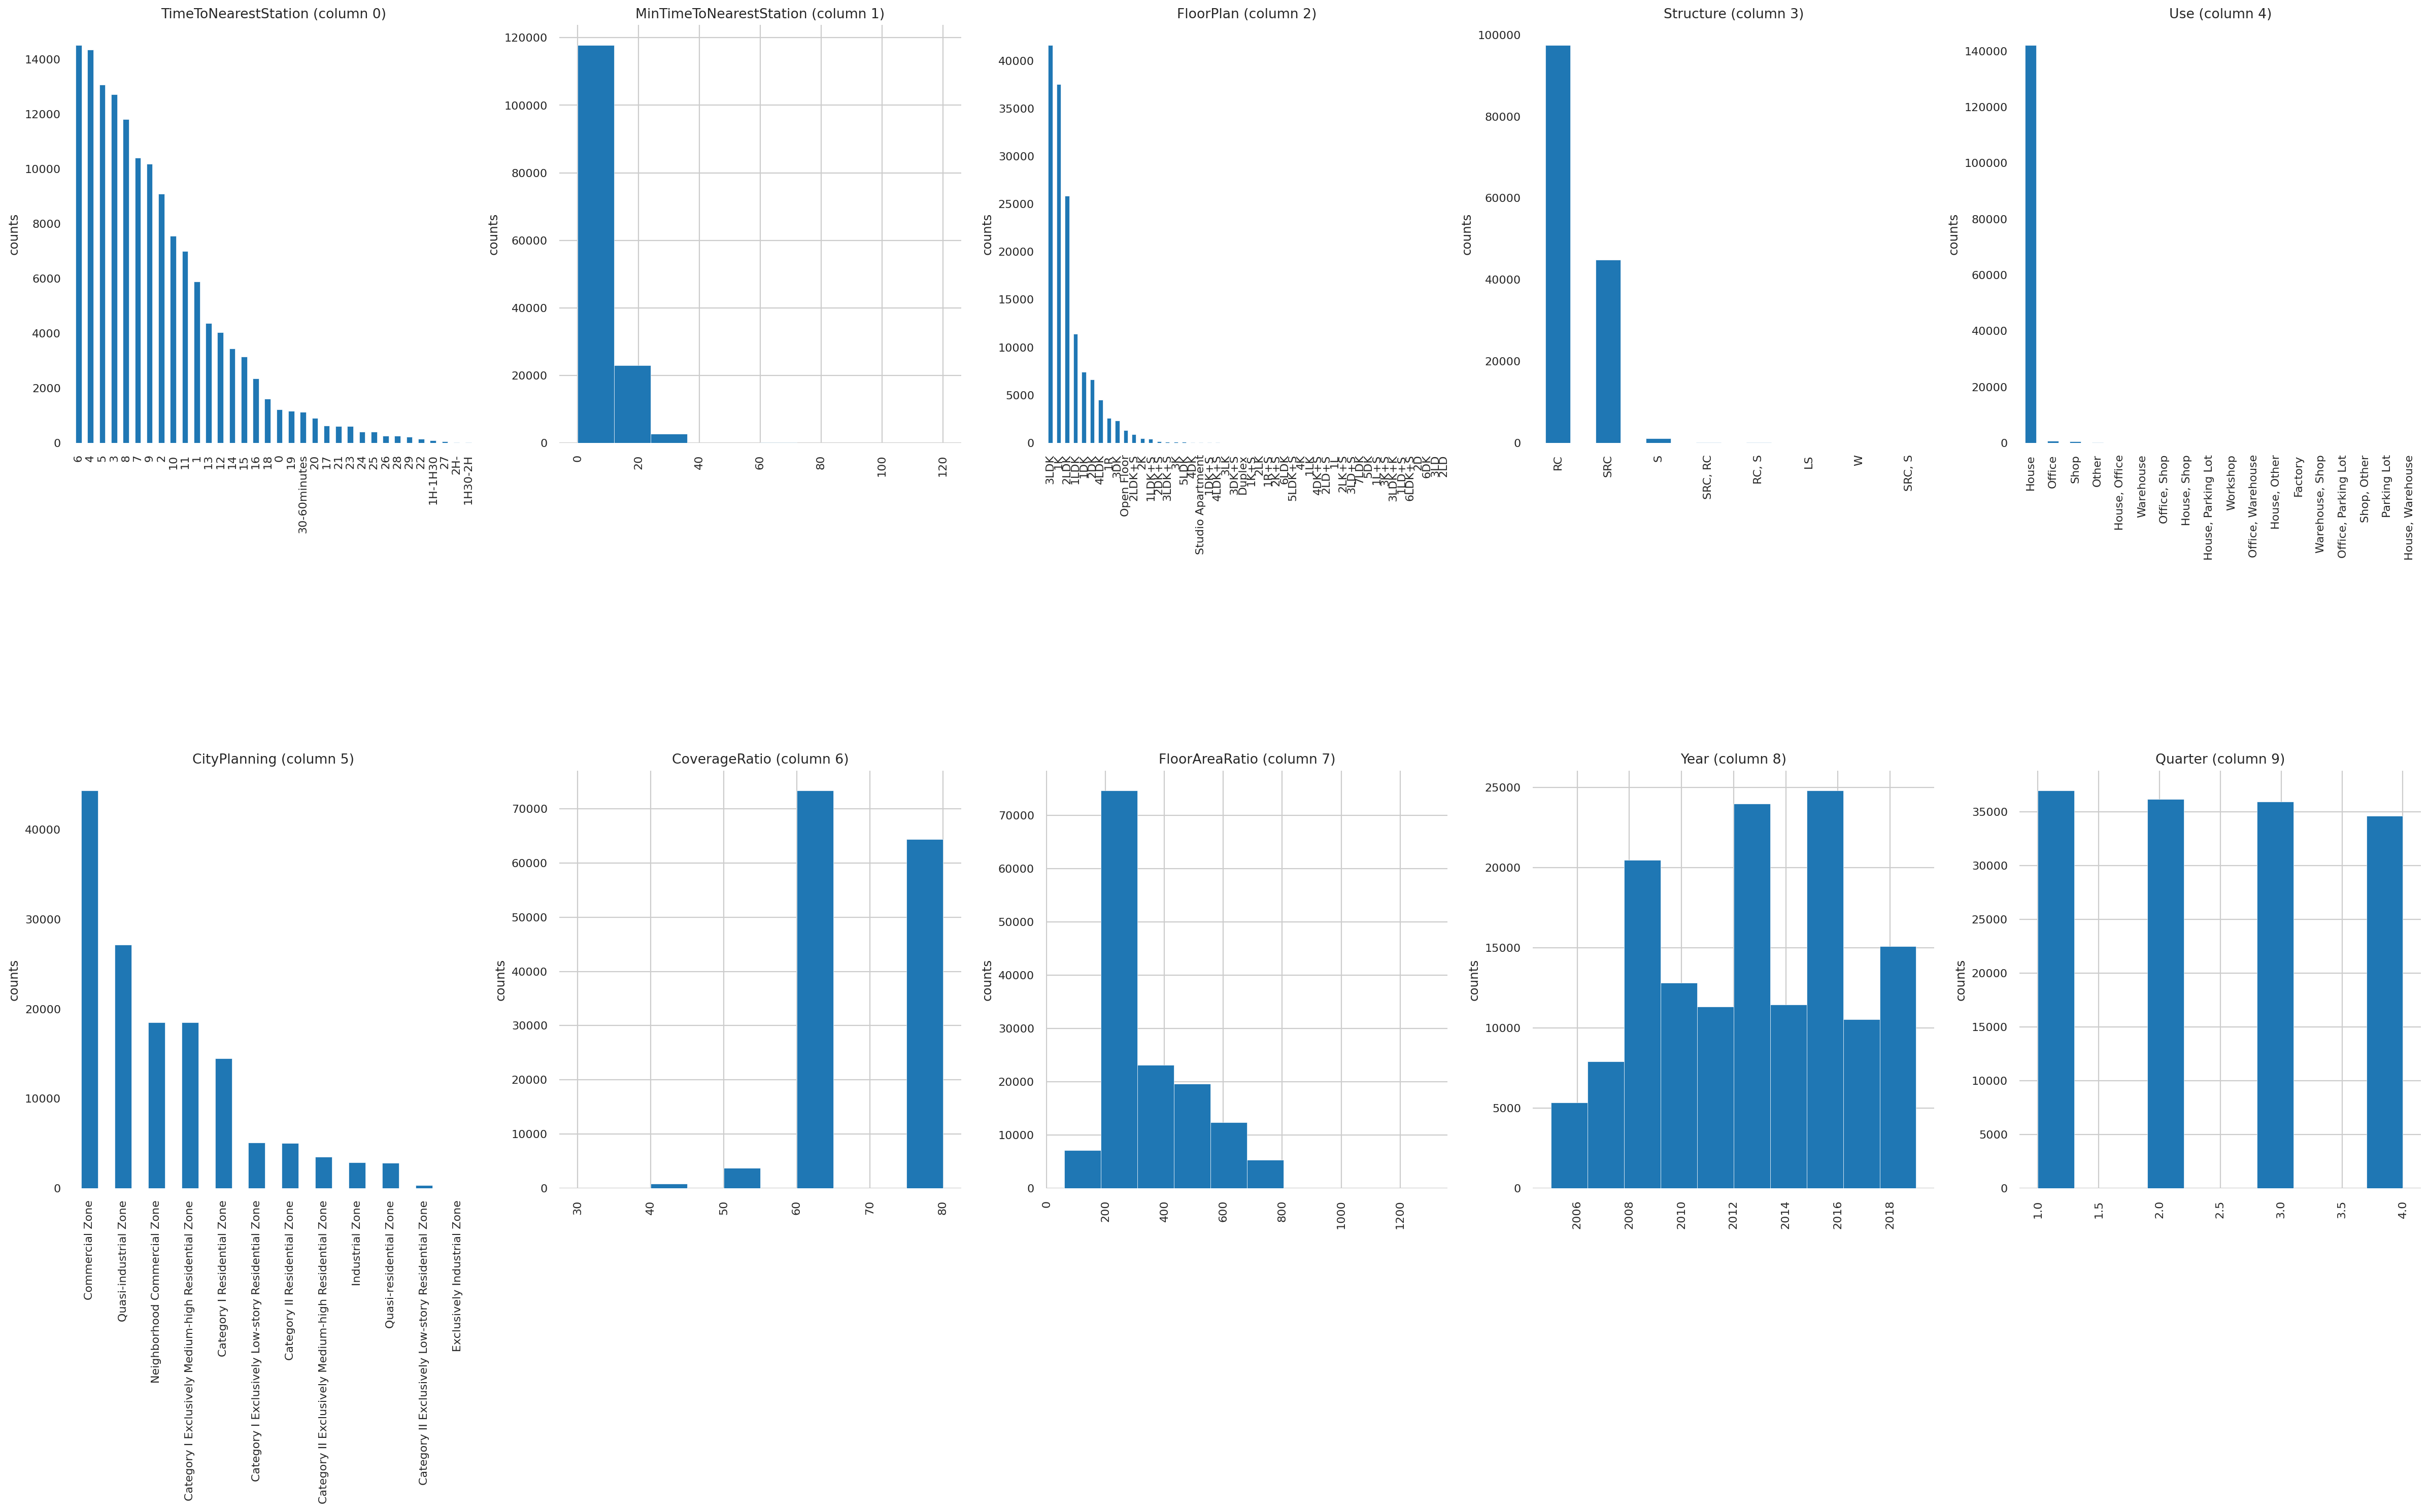

In [ ]:
plotPerColumnDistribution(df, 10, 5)

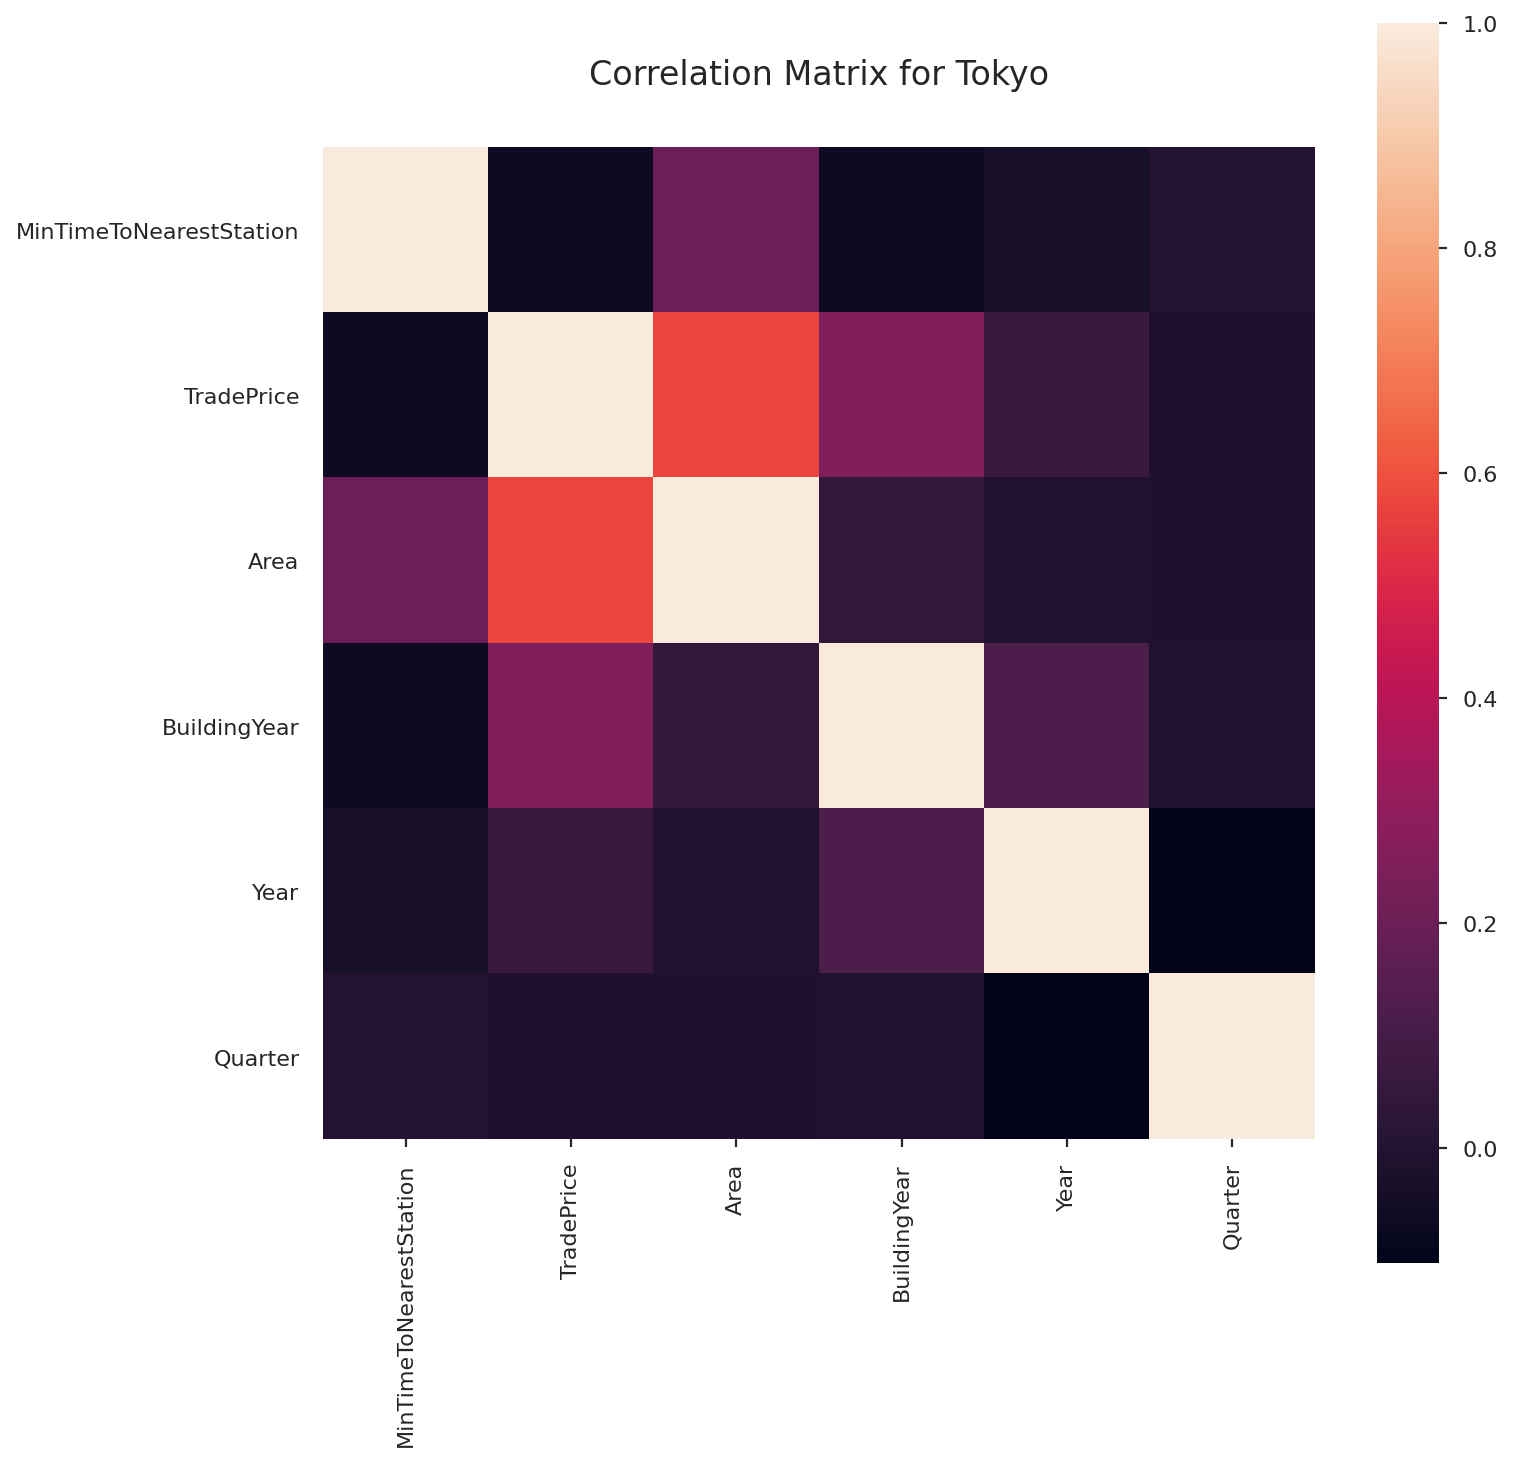

In [ ]:
plotCorrelationMatrix(df, 10)

# 모델 학습을 위한 타겟 설정 및 데이터 분리


In [ ]:
target = 'TradePrice'
features = list(df.columns)
features.remove('TradePrice')

train, val = train_test_split(df, train_size=0.80, test_size=0.20, random_state=2)
train, test = train_test_split(train, train_size=0.80, test_size=0.20, random_state=2)

In [ ]:
X_train = train.drop(columns=target)
y_train = train[target]
X_val = val.drop(columns=target)
y_val = val[target]
X_test = test.drop(columns=target)

In [ ]:
train.shape, val.shape, test.shape

((102424, 9), (32008, 9), (25607, 9))

# 모델 성능 평가 지표를 위한 베이스 라인 설정 및 분석 모델링 , Fitting
### 모델 성능을 평가하는 다양한 지표가 있는데 부동산의 가격을 평가하는 
### 지표는 선형으로 이뤄져있다고 가정하여 R^2 값으로 모델
### 성능을 평가하려고 가정함. 

In [ ]:
y, X = dmatrices("TradePrice~"+num_features, data = vif_data_num, return_type = "dataframe")

In [ ]:
result = sm.OLS(y, X).fit()

print(result.summary())

                            OLS Regression Results                            
Dep. Variable:             TradePrice   R-squared:                       0.572
Model:                            OLS   Adj. R-squared:                  0.572
Method:                 Least Squares   F-statistic:                 2.645e+04
Date:                Sat, 03 Jul 2021   Prob (F-statistic):               0.00
Time:                        16:04:02   Log-Likelihood:            -2.4640e+06
No. Observations:              138266   AIC:                         4.928e+06
Df Residuals:                  138258   BIC:                         4.928e+06
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept               -1

# 모델 파이프라인 구축 및 훈련 데이터 평가값 결과
### 모델 선정은 Linear , Ridge ,Rasso , XGB Boost 
### 4가지를 비교하려고 한다. 컬럼을 최대한으로 적게 쓰려고 하였고, 
### 컬럼에 대한 처리를 따로 해주지 않고 간단하게 만들었기 때문에
### 복잡한 모델보다는 단순한 모델이 평가지표가 좋을것으로 예상이 된다.

# *Linear*

In [ ]:
pipe = make_pipeline(
    TargetEncoder(),
    SimpleImputer(),
    LinearRegression()
)

params = {
    'simpleimputer__strategy' : ['median', 'mean']
}

reg = GridSearchCV(
    pipe,
    param_grid=params,
    cv = 5,
    n_jobs = -1,
    verbose = 1
    )

reg.fit(X_train, y_train)

Fitting 5 folds for each of 2 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    6.9s finished


GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('targetencoder',
                                        TargetEncoder(cols=None,
                                                      drop_invariant=False,
                                                      handle_missing='value',
                                                      handle_unknown='value',
                                                      min_samples_leaf=1,
                                                      return_df=True,
                                                      smoothing=1.0,
                                                      verbose=0)),
                                       ('simpleimputer',
                                        SimpleImputer(add_indicator=False,
                                                      copy=True,
                                                      fill_value=None,
                 

In [ ]:
linear_model = reg.best_estimator_
print('Best parameters : ', reg.best_params_)
print('Best score : ', reg.best_score_)

Best parameters :  {'simpleimputer__strategy': 'median'}
Best score :  0.7063164572483493


In [ ]:
linear = linear_model.named_steps['linearregression']

In [ ]:
r2_linear = linear_model.score(X_val, y_val)
print('R square : ', r2_linear)

R square :  0.7211781272840394


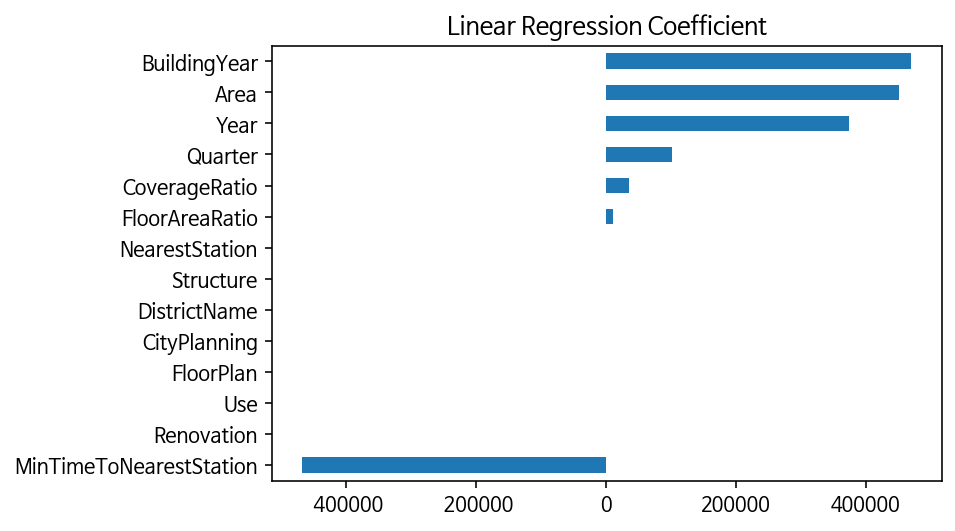

In [ ]:
coefficient = pd.Series(linear.coef_, features).sort_values()
coefficient.plot.barh()
plt.title('Linear Regression Coefficient')
plt.show()

# *Ridge*

In [ ]:
pipe = make_pipeline(
    TargetEncoder(),
    SimpleImputer(),
    Ridge()
)

params = {
    'simpleimputer__strategy' : ['median', 'mean'],
    'ridge__alpha' : [0.001, 0.01, 0.1, 0.3, 0.5, 0.7, 0.9, 1]
}

reg2 = GridSearchCV(
    pipe,
    param_grid=params,
    cv = 5,
    n_jobs = -1,
    verbose = 1
    )

reg2.fit(X_train, y_train)

Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   24.2s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:   41.7s finished


GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('targetencoder',
                                        TargetEncoder(cols=None,
                                                      drop_invariant=False,
                                                      handle_missing='value',
                                                      handle_unknown='value',
                                                      min_samples_leaf=1,
                                                      return_df=True,
                                                      smoothing=1.0,
                                                      verbose=0)),
                                       ('simpleimputer',
                                        SimpleImputer(add_indicator=False,
                                                      copy=True,
                                                      fill_value=None,
                 

In [ ]:
ridge_model = reg2.best_estimator_
print('Best parameters : ', reg2.best_params_)
print('Best score : ', reg2.best_score_)

Best parameters :  {'ridge__alpha': 0.001, 'simpleimputer__strategy': 'median'}
Best score :  0.7063164572484691


In [ ]:
ridge = ridge_model.named_steps['ridge']

In [ ]:
r2_ridge = ridge_model.score(X_val, y_val)
print('R square : ', r2_ridge)

R square :  0.7211781272815145


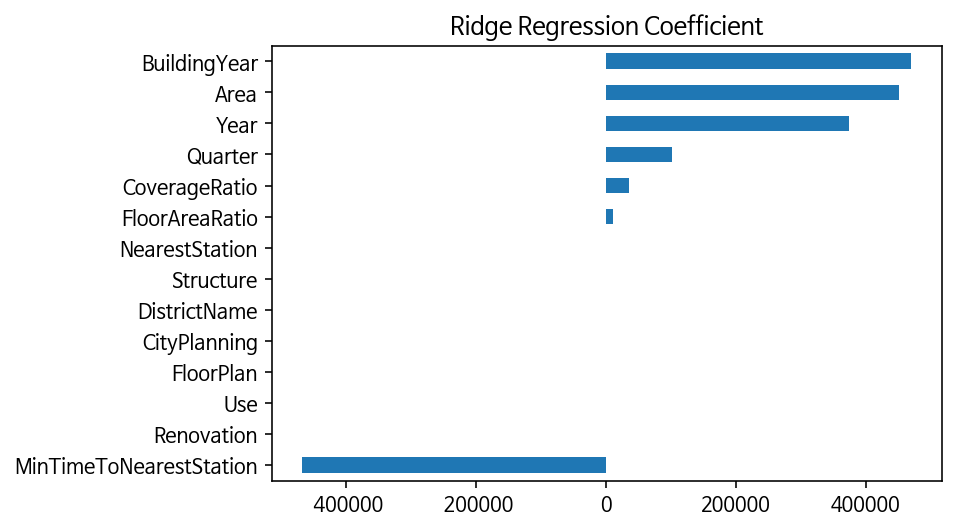

In [ ]:
coefficient = pd.Series(ridge.coef_, features).sort_values()
coefficient.plot.barh()
plt.title('Ridge Regression Coefficient')
plt.show()

# *Lasso*

In [ ]:
pipe = make_pipeline(
    TargetEncoder(),
    SimpleImputer(),
    Lasso()
)

params = {
    'simpleimputer__strategy' : ['median', 'mean'],
    'lasso__alpha' : [0.001, 0.01, 0.1, 0.3, 0.5, 0.7, 0.9, 1]
}

reg4 = GridSearchCV(
    pipe,
    param_grid=params,
    cv = 5,
    n_jobs = -1,
    verbose = 1
    )

reg4.fit(X_train, y_train)

Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:  1.7min finished


GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('targetencoder',
                                        TargetEncoder(cols=None,
                                                      drop_invariant=False,
                                                      handle_missing='value',
                                                      handle_unknown='value',
                                                      min_samples_leaf=1,
                                                      return_df=True,
                                                      smoothing=1.0,
                                                      verbose=0)),
                                       ('simpleimputer',
                                        SimpleImputer(add_indicator=False,
                                                      copy=True,
                                                      fill_value=None,
                 

In [ ]:
lasso_model = reg4.best_estimator_
print('Best parameters : ', reg4.best_params_)
print('Best score : ', reg4.best_score_)

Best parameters :  {'lasso__alpha': 0.001, 'simpleimputer__strategy': 'median'}
Best score :  0.7063164572488383


In [ ]:
lasso = lasso_model.named_steps['lasso']

In [ ]:
r2_lasso = lasso_model.score(X_val, y_val)
print('R square : ', r2_lasso)

R square :  0.7211781272832154


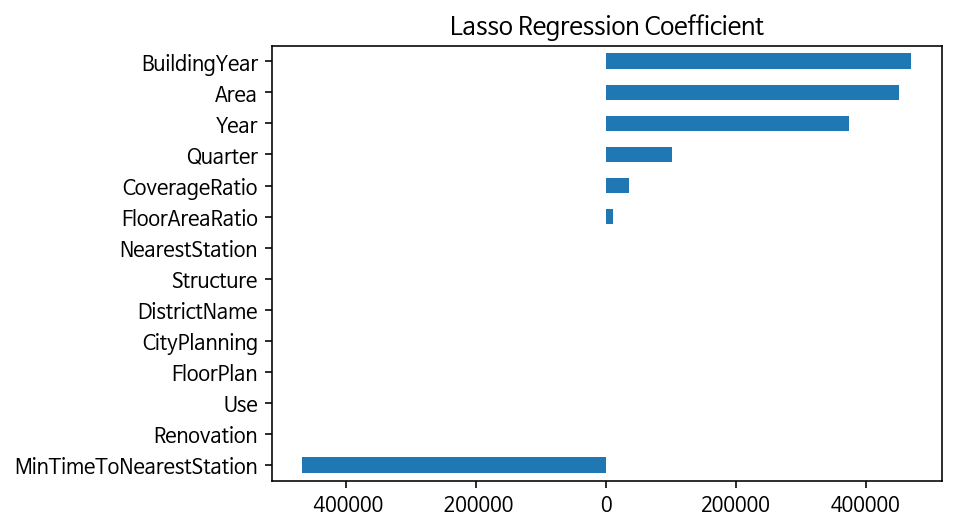

In [ ]:
coefficient = pd.Series(lasso.coef_, features).sort_values()
coefficient.plot.barh()
plt.title('Lasso Regression Coefficient')
plt.show()

# *XGB*

In [ ]:
# XGB 모델
pipe = make_pipeline(
    TargetEncoder(),
    SimpleImputer(),
    XGBRegressor(
        random_state = 2,
        n_jobs = -1
    )
)

params = {
    'simpleimputer__strategy' : ['median', 'mean'],
    'xgbregressor__learning_rate' : [0.1, 0.2, 0.3],

}

reg3 = GridSearchCV(
    pipe,
    param_grid=params,
    cv = 5,
    n_jobs = -1,
    verbose = 1
    )

reg3.fit(X_train, y_train)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  1.5min finished


[16:56:28] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('targetencoder',
                                        TargetEncoder(cols=None,
                                                      drop_invariant=False,
                                                      handle_missing='value',
                                                      handle_unknown='value',
                                                      min_samples_leaf=1,
                                                      return_df=True,
                                                      smoothing=1.0,
                                                      verbose=0)),
                                       ('simpleimputer',
                                        SimpleImputer(add_indicator=False,
                                                      copy=True,
                                                      fill_value=None,
                 

In [ ]:
xgb_model = reg3.best_estimator_
print('Best parameters : ', reg3.best_params_)
print('Best score : ', reg3.best_score_)

Best parameters :  {'simpleimputer__strategy': 'median', 'xgbregressor__learning_rate': 0.3}
Best score :  0.7170304557566642


In [ ]:
r2_xgb = xgb_model.score(X_val, y_val)
print('R square : ', r2_xgb)

R square :  0.713766911923257


##  *실제로 4가지 모델의 평가지표의 성능수준 차이가 눈에 띄게 적은걸 확인할수있다.*

# 실제 데이터와 모델학습을 통한 데이터 비교
## 실제 데이터와 약 14%의 차이가 있는것으로 예측되었다.

In [ ]:
row = X_val.iloc[[1]]  
row

,DistrictName,NearestStation,MinTimeToNearestStation,FloorPlan,Area,BuildingYear,Structure,Use,CityPlanning,CoverageRatio,FloorAreaRatio,Year,Quarter,Renovation
No,,,,,,,,,,,,,,
179972,Chitosedai,Chitosefunabashi,10.0,2LDK,55,1984.0,RC,House,Category II Exclusively Medium-high Residentia...,60.0,200.0,2013,2,Done


In [ ]:
# 실제 데이터
y_val.iloc[[1]]

No
179972    35000000
Name: TradePrice, dtype: int64

In [ ]:
# 모델로 예측한 데이터 값
explainer.expected_value[0]

30439153.87315178

# 컬럼이 예측값에 있어서 얼마나 영향을 주는지 Shap plot을 이용해 그래프로 표현
### Building Year(건설년도)나 Area(면적) 같은 선형적인 요소들이 많이 반영되어있는걸 볼수있음 
### 신축일수록 , 넓은평수 일수록 가격에 반영되는 퍼센테이지가 높음

In [ ]:
import shap

explainer = shap.TreeExplainer(xgb)
shap_values = explainer.shap_values(X_val_trans_df.iloc[:100])

### Draw SHAP plots ###
shap.initjs()
shap.force_plot(
    base_value = explainer.expected_value,
    shap_values = shap_values,
    features = X_val_trans_df
)

In [ ]:
def predict(Floorplan, Area, Year, Quarter,MinTimeToNearestStation):

    # input 생성
    df = pd.DataFrame(
        data=[[Floorplan, Area, Year, Quarter,MinTimeToNearestStation]], 
        columns=['FloorPlan','Area','Year','Quarter','MinTimeToNearestStation']
    )

    # 예측
    pred = xgb.predict(df)[0]

    # Shap value를 계산
    explainer = shap.TreeExplainer(xgb)
    shap_values = explainer.shap_values(df)

    # Shap value, 특성이름, 특성값을 가지는 Series를 만듬
    feature_names = df.columns
    feature_values = df.values[0]
    shaps = pd.Series(shap_values[0], zip(feature_names, feature_values))

    # 결과를 프린트 
    result = f'평균가격: ${explainer.expected_value[0]:,.0f} \n'
    result += f'예측가격: ${pred:,.0f}. \n'
    result += shaps.to_string()
    print(result)


    # SHAP Force Plot
    shap.initjs()
    return shap.force_plot(
        base_value=explainer.expected_value, 
        shap_values=shap_values, 
        features=df
    )

In [ ]:
# PDP isolation

from pdpbox.pdp import pdp_isolate, pdp_plot\

xgb = XGBRegressor(
        random_state = 2,
        n_jobs = -1,
        learning_rate 
        = 0.1
)
encoder = xgb_model.named_steps['targetencoder']
imp = xgb_model.named_steps['simpleimputer']


trans = make_pipeline(
    encoder,
    imp
)

X_train_trans = trans.transform(X_train)
X_val_trans = trans.transform(X_val)

X_train_trans_df = pd.DataFrame(X_train_trans, columns = features)
X_val_trans_df = pd.DataFrame(X_val_trans, columns = features)

In [ ]:
eval_set = [(X_train_trans_df, y_train),
            (X_val_trans_df, y_val)]

xgb.fit(X_train_trans_df, y_train,
        eval_set = eval_set,
        eval_metric = 'rmse',
        early_stopping_rounds = 50)

[16:57:45] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:3.34747e+07	validation_1-rmse:3.38292e+07
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 50 rounds.
[1]	validation_0-rmse:3.07555e+07	validation_1-rmse:3.11016e+07
[2]	validation_0-rmse:2.83614e+07	validation_1-rmse:2.87049e+07
[3]	validation_0-rmse:2.62443e+07	validation_1-rmse:2.65855e+07
[4]	validation_0-rmse:2.4387e+07	validation_1-rmse:2.47274e+07
[5]	validation_0-rmse:2.27416e+07	validation_1-rmse:2.30771e+07
[6]	validation_0-rmse:2.13071e+07	validation_1-rmse:2.16364e+07
[7]	validation_0-rmse:2.00595e+07	validation_1-rmse:2.03898e+07
[8]	validation_0-rmse:1.89544e+07	validation_1-rmse:1.92755e+07
[9]	validation_0-rmse:1.80086e+07	validation_1-rmse:1.83255e+07
[10]	validation_0-rmse:1.71882e+07	validation_1-rmse:1.74985e+07
[11]	valid

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
             n_jobs=-1, nthread=None, objective='reg:linear', random_state=2,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

# 한계점 및 결론
### Column의 결측치가 너무 많은 데이터 분석을 진행하여 전처리가 따로 하기 어려웠다.
### 당연하게 예상 할수있는 매물의 가격을 결정하는 요소들로만(ex신축, 넓은평수..) 예측이 진행된것 같고
### 부동산에 관련된 배경지식이 적어 모델 성능에 반영되는 요소를 찾기가 힘들었다.
### 평가지표가 무엇을 의미하는지 상대방은 물론 나 자신에게도 설명하기가 어려움을 느낀 프로젝트였다.
### Daycon에 있는 비슷한 프로젝트에 참가해 데이터의 상관관계를 모델 파라미터 조정과 Column간의 관계를 파악해 접근해보록 해야겠다.